![](https://www.dreamfab.com/wp-content/uploads/12748105_1735270656706975_9117780761768802940_o-700x342.png)

userid: A unique number that identifies each player.

version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a)

sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.

retention_1: Did the player come back and play 1 day after installing?

retention_7: Did the player come back and play 7 days after installing?

#### **IMPORT LIBRARIES**

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import MultiComparison

#### **SOME OPTIONS**

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### **CLOSE WARNINGS**

In [3]:
import warnings
warnings.filterwarnings("ignore")
#Ignore specific warnings by category
warnings.filterwarnings("ignore", category=FutureWarning)

#### **LOAD AND CHECK DATA**

In [4]:
df = pd.read_csv("/kaggle/input/mobile-games-ab-testing/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
def summary_data(df,head=5):
    func = {"Head": ".head(head)",
            "Info": ".info()",
           "Shape":".shape",
           "Ndim":".ndim",
           "Null": ".isnull().sum()",
           "Describe":".describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]).T"}

    for n,f in func.items():
        print("\n################### ",n, " ###################\n")
        print(eval("df" + f))

summary_data(df)


###################  Head  ###################

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

###################  Info  ###################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None

###################  Shape  ###################

(90189

#### **DATA VISUALIZATION**

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


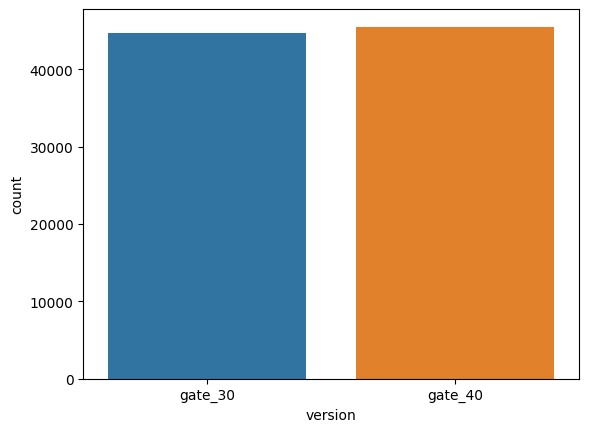

<Axes: >

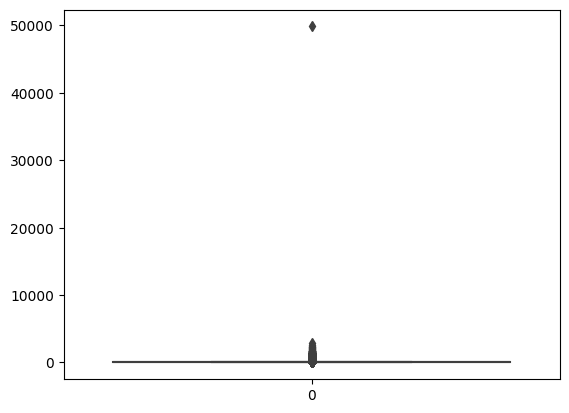

In [6]:
display(df.groupby('version').count())

sns.countplot(x='version', data=df)
plt.show()

sns.boxplot(df['sum_gamerounds'])


#### **A/B TESTING IMPLEMENTATION**

* This code is used during analysis to mitigate the impact of outliers or clean the dataset. Outliers can mislead data analysis and distort results. Therefore, I used this code to suppress outliers and make the data analysis more reliable.

In [7]:
Q25 = np.quantile(df['sum_gamerounds'],0.25)
Q75 = np.quantile(df['sum_gamerounds'],0.75)
Interquantile_Range = Q75 - Q25

Include_range = (max(min(df['sum_gamerounds']), Q25-1.5*Interquantile_Range),
                min(max(df['sum_gamerounds']), Q75+1.5*Interquantile_Range))

df_without_outlier = df[
    (df['sum_gamerounds'] > Include_range[0]) &
    (df['sum_gamerounds'] < Include_range[1])]

* After suppressing the outliers, visualize the data.

<Axes: >

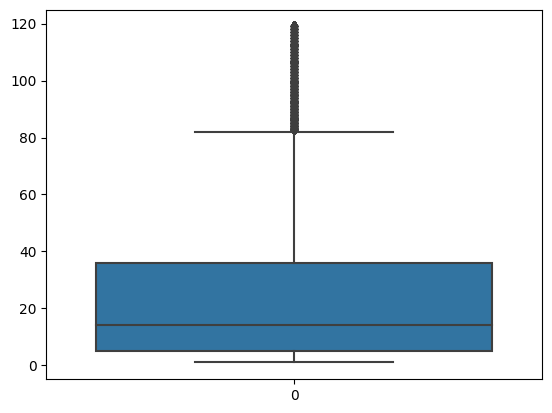

In [8]:
sns.boxplot(df_without_outlier['sum_gamerounds'])

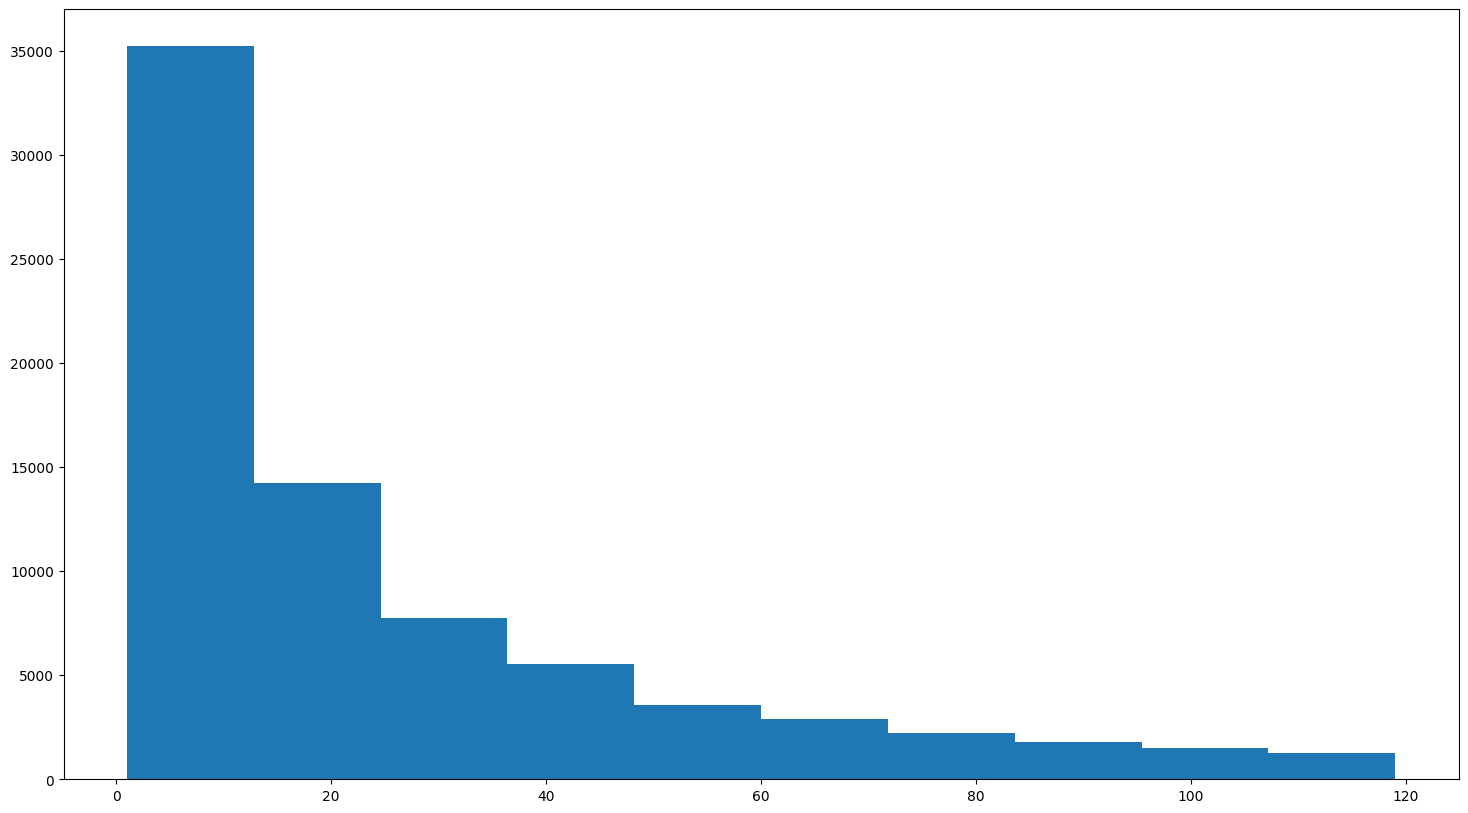

In [9]:
fig,ax=plt.subplots(figsize =(18,10))
ax.hist(df_without_outlier['sum_gamerounds'])
plt.show()

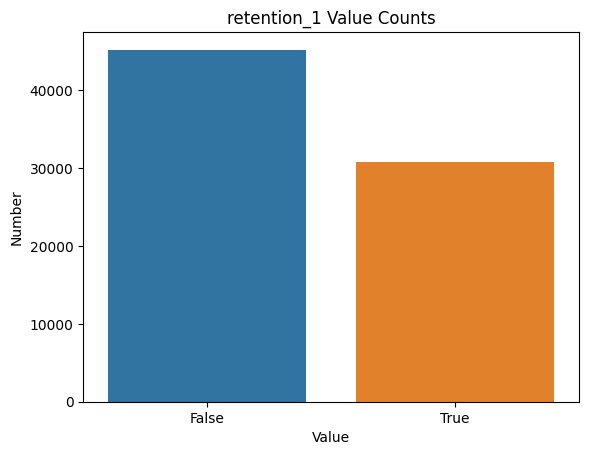

In [10]:

value_counts = df_without_outlier["retention_1"].value_counts()

sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title("retention_1 Value Counts")
plt.xlabel("Value")
plt.ylabel("Number")
plt.show()

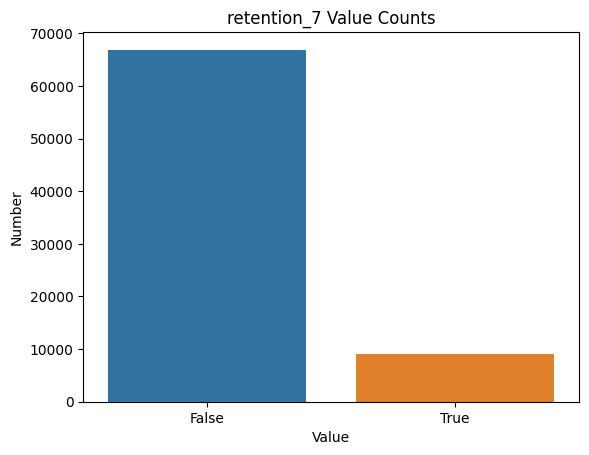

In [11]:
value_counts_2 = df_without_outlier["retention_7"].value_counts()

sns.barplot(x=value_counts.index, y=value_counts_2.values)
plt.title("retention_7 Value Counts")
plt.xlabel("Value")
plt.ylabel("Number")
plt.show()

* This code calculates basic statistical summaries for the "sum_gamerounds," "retention_1," and "retention_7" columns for different game versions. This can be useful for comparing and analyzing the data across different versions of the game.

In [12]:
df_without_outlier.groupby("version").agg({"sum_gamerounds":["count", "median", "mean", "std", "max"],
                          "retention_1":["count", "median", "mean", "std", "max"],
                          "retention_7":["count", "median", "mean", "std", "max"]})

sum_gamerounds                                 retention_1          \
                 count   median     mean      std  max       count  median   
version                                                                      
gate_30          37656 14.00000 25.06211 27.09794  119       37656 0.00000   
gate_40          38263 14.00000 25.16800 27.75218  119       38263 0.00000   

                              retention_7                                
           mean     std   max       count  median    mean     std   max  
version                                                                  
gate_30 0.40750 0.49138  True       37656 0.00000 0.12330 0.32879  True  
gate_40 0.40209 0.49033  True       38263 0.00000 0.11455 0.31848  True

Based on these numbers, there may not be a significant difference in the average game rounds played at Gate_30 and Gate_40. However, this difference could have occurred by chance and might need to be statistically tested.

* Step 1 - Formulate Hypotheses:

Null Hypothesis (H0): μ1 = μ2 ("There is no statistically significant difference in the means of the number of game rounds played by players at Gate_30 and Gate_40.")

Alternative Hypothesis (H1): μ1 ≠ μ2 ("There is a statistically significant difference in the means of the number of game rounds played by players at Gate_30 and Gate_40.")

* Step 2 - Assumption Checks:

Normality Assumption

Homogeneity of Variance

* Step 3 - Normality Assumption Hypothesis:

H0: The normal distribution assumption is met.

H1: The normal distribution assumption is not met.

* Step 4 - Assumption of Homogeneity of Variance:

H0: Variances are homogenous.

H1: Variances are not homogenous.

#### **Normality Check** ####

* p-value = 0.0000 < alpha = 0.05 H0 is rejected. The normal distribution assumption is not met.

In [13]:
test_stat, pvalue = shapiro(df_without_outlier.loc[df_without_outlier["version"] == "gate_30", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.8087, p-value = 0.0000


* p-value = 0.0000 < alpha = 0.05 H0 is rejected. The normal distribution assumption is not met.

In [14]:
test_stat, pvalue = shapiro(df_without_outlier.loc[df_without_outlier["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.8003, p-value = 0.0000


#### **Variance Homogeneity Control** ####

* p-value = 0.0948 > alpha = 0.05. H0 is not rejected. Variances are homogenous. Homogeneity of variances is no longer important because the data does not follow a normal distribution. Therefore, we will apply a non-parametric test.

In [15]:
test_stat, pvalue = levene(df_without_outlier.loc[df_without_outlier["version"] == "gate_30", "sum_gamerounds"], 
                           df_without_outlier.loc[df_without_outlier["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 2.7916, p-value = 0.0948


#### **MannWhitneyU Test** ####

* p-value= 0.828 > alpha = 0.05 H0 is not rejected. There is no statistically significant difference in the number of game rounds played between the Gate_30 and Gate_40 versions.

In [16]:
test_stat, pvalue = mannwhitneyu(df_without_outlier.loc[df_without_outlier["version"] == "gate_30", "sum_gamerounds"], 
                           df_without_outlier.loc[df_without_outlier["version"] == "gate_40", "sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 725650246.5000, p-value = 0.0828


* I removed the "version" from the data because there was no relationship.

In [17]:
df_without_outlier = df_without_outlier.drop('version', axis=1)

* I converted the data types of "retention_1" and "retention_7" from "bool" to "int" to be able to segment and analyze them.

In [18]:
df_without_outlier['retention_1'] = df_without_outlier['retention_1'].astype(int)
df_without_outlier['retention_7'] = df_without_outlier['retention_7'].astype(int)
df_without_outlier.head()

,userid,sum_gamerounds,retention_1,retention_7
0,116,3,0,0
1,337,38,1,0
3,483,1,0,0
7,1444,2,0,0
8,1574,108,1,1


* I combined the values of "retention_1" and "retention_7" into a new column (RET1_RET7) to assign segments.

In [19]:
df_without_outlier["RET1_RET7"] = (df_without_outlier["retention_1"].astype(str) +
                    df_without_outlier["retention_7"].astype(str))
df_without_outlier

,userid,sum_gamerounds,retention_1,retention_7,RET1_RET7
0,116,3,0,0,00
1,337,38,1,0,10
3,483,1,0,0,00
7,1444,2,0,0,00
8,1574,108,1,1,11
...,...,...,...,...,...
90184,9999441,97,1,0,10
90185,9999479,30,0,0,00
90186,9999710,28,1,0,10
90187,9999768,51,1,0,10


* I classified the segments and assigned them as variables.

In [20]:
seg_map = { 
    r"[0][0]": "churn",
    r"[1][0]": "churn after the first day",
    r"[1][1]": "top users",
}

In [21]:
df_without_outlier["segment"] = df_without_outlier["RET1_RET7"].replace(seg_map, regex=True)
df_without_outlier

,userid,sum_gamerounds,retention_1,retention_7,RET1_RET7,segment
0,116,3,0,0,00,churn
1,337,38,1,0,10,churn after the first day
3,483,1,0,0,00,churn
7,1444,2,0,0,00,churn
8,1574,108,1,1,11,top users
...,...,...,...,...,...,...
90184,9999441,97,1,0,10,churn after the first day
90185,9999479,30,0,0,00,churn
90186,9999710,28,1,0,10,churn after the first day
90187,9999768,51,1,0,10,churn after the first day


This code performs various statistical summaries and calculations for a specific column, "sum_gamerounds," within a DataFrame called "df_without_outlier."

First, it groups the data by the "segment" column and calculates statistical computations on the "sum_gamerounds" column:

* 'mean': Calculates the mean of the "sum_gamerounds" column for each group.
* 'median': Calculates the median of the "sum_gamerounds" column for each group.
* 'std': Computes the standard deviation of the "sum_gamerounds" column for each group.

These calculations are performed separately for each segment grouped by the "segment" column, and the results are stored in a DataFrame named "stats."

Next, it groups the data again by the "segment" column and calculates detailed statistical summaries for the "sum_gamerounds" column using the describe() function. These summaries include information about the distribution, central tendencies, and spreads of the groups. The results are stored in a DataFrame named "describe."

To determine the number of data points in each group within the "segment" column, it uses the "value_counts()" function. The counts are stored in a Series named "count."

The function gathers the results into a dictionary and returns it. The dictionary contains the relevant calculations and data under keys such as "mean," "median," "std," "describe," and "count." This allows you to access different statistical summaries for the "sum_gamerounds" column for each "segment."

In [22]:
def calculate_segment_stats(df):
    
    stats = df_without_outlier.groupby('segment')['sum_gamerounds'].agg(['mean', 'median', 'std'])
    
   
    describe = df_without_outlier.groupby('segment')['sum_gamerounds'].describe().T
    
    
    count = df_without_outlier['segment'].value_counts()
    
    return {
        'mean': stats['mean'],
        'median': stats['median'],
        'std': stats['std'],
        'describe': describe,
        'count': count
    }


In [23]:
dictionary = calculate_segment_stats(df_without_outlier)

In [24]:
for k,v in dictionary.items():
    print(v)
    print("\n")

segment
01                          40.98588
churn                       11.83356
churn after the first day   36.48249
top users                   63.63541
Name: mean, dtype: float64


segment
01                          34.00000
churn                        6.00000
churn after the first day   29.00000
top users                   63.00000
Name: median, dtype: float64


segment
01                          30.46891
churn                       15.06498
churn after the first day   27.44953
top users                   30.86842
Name: std, dtype: float64


segment         01       churn  churn after the first day  top users
count   2904.00000 42285.00000                24608.00000 6122.00000
mean      40.98588    11.83356                   36.48249   63.63541
std       30.46891    15.06498                   27.44953   30.86842
min        1.00000     1.00000                    1.00000    1.00000
25%       16.00000     3.00000                   15.00000   39.00000
50%       34.00000     6.00000

* Let's consider that a gaming company wants to give 2000 coins as a gift to users who churn after the first day. After defining our target users as those who churn after the first day, I created a variable called "give_a_gift."

In [25]:
target_users = df_without_outlier[df_without_outlier["segment"] == "churn after the first day"]
target_users

,userid,sum_gamerounds,retention_1,retention_7,RET1_RET7,segment
1,337,38,1,0,10,churn after the first day
12,2132,30,1,0,10,churn after the first day
13,2179,39,1,0,10,churn after the first day
15,2382,73,1,0,10,churn after the first day
16,2392,14,1,0,10,churn after the first day
...,...,...,...,...,...,...
90181,9998733,10,1,0,10,churn after the first day
90182,9999178,21,1,0,10,churn after the first day
90184,9999441,97,1,0,10,churn after the first day
90186,9999710,28,1,0,10,churn after the first day


In [26]:
target_users["give a gift"] = "2000 coins"
target_users

,userid,sum_gamerounds,retention_1,retention_7,RET1_RET7,segment,give a gift
1,337,38,1,0,10,churn after the first day,2000 coins
12,2132,30,1,0,10,churn after the first day,2000 coins
13,2179,39,1,0,10,churn after the first day,2000 coins
15,2382,73,1,0,10,churn after the first day,2000 coins
16,2392,14,1,0,10,churn after the first day,2000 coins
...,...,...,...,...,...,...,...
90181,9998733,10,1,0,10,churn after the first day,2000 coins
90182,9999178,21,1,0,10,churn after the first day,2000 coins
90184,9999441,97,1,0,10,churn after the first day,2000 coins
90186,9999710,28,1,0,10,churn after the first day,2000 coins
